# Location Intelligence Data Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.model_selection import train_test_split
np.random.seed = 42

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import haversine_distances

import tensorflow as tf
import tensorflow_hub as hub
from collections import Counter

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from scipy.spatial import distance
from sklearn_extra.cluster import KMedoids

from sklearn.base import BaseEstimator, TransformerMixin
import copy
from sklearn.cluster import AgglomerativeClustering
import geopandas as gpd
from scipy.cluster import hierarchy

In [9]:
X_train = pd.read_csv('./DATA/X_train.csv')
X_val = pd.read_csv('./DATA/X_val.csv')
X_train_lat_long = pd.read_csv('./DATA/X_train_lat_long.csv')
X_val_lat_long = pd.read_csv('./DATA/X_val_lat_long.csv')

## Modelling

In [3]:
def metrics_plots(X, max_k=10):

    score = []
    score_kmeans_s = []
    score_kmeans_c = []
    score_kmeans_d = []

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state= 101)
        predictions = kmeans.fit_predict(X)
        # Calculate cluster validation metrics and append to lists of metrics
        score.append(kmeans.score(X))
        score_kmeans_s.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))
        score_kmeans_c.append(calinski_harabasz_score(X, kmeans.labels_))
        score_kmeans_d.append(davies_bouldin_score(X, predictions))

    list_scores = [score, score_kmeans_s, score_kmeans_c, score_kmeans_d] 
    # Elbow Method plot
    list_title = ['Within-cluster sum of squares', 'Silhouette Score', 'Calinski Harabasz', 'Davies Bouldin'] 
    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

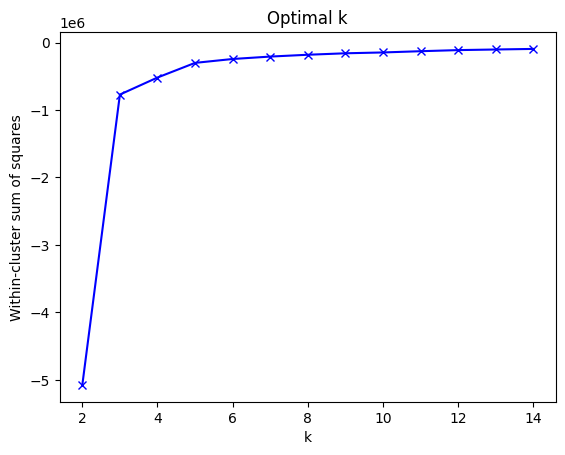

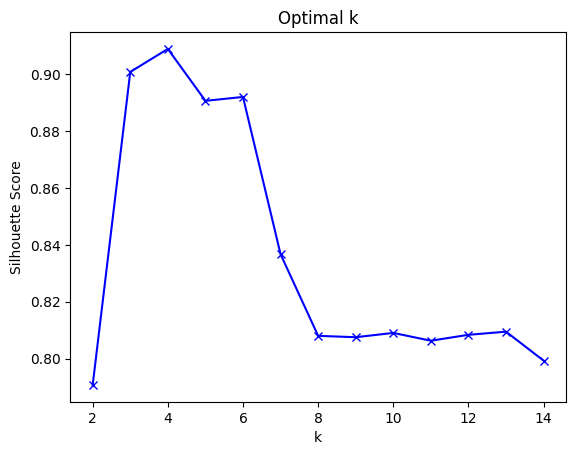

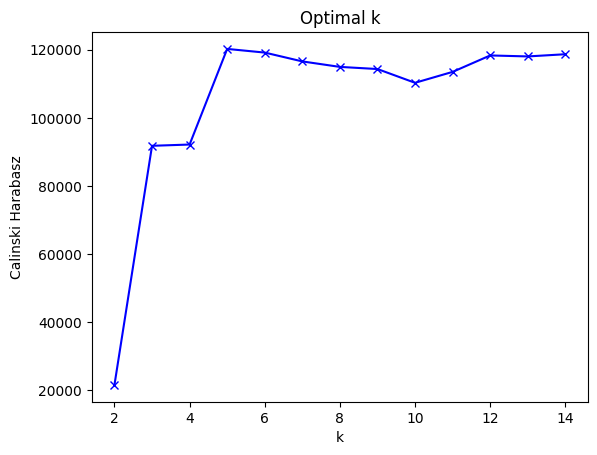

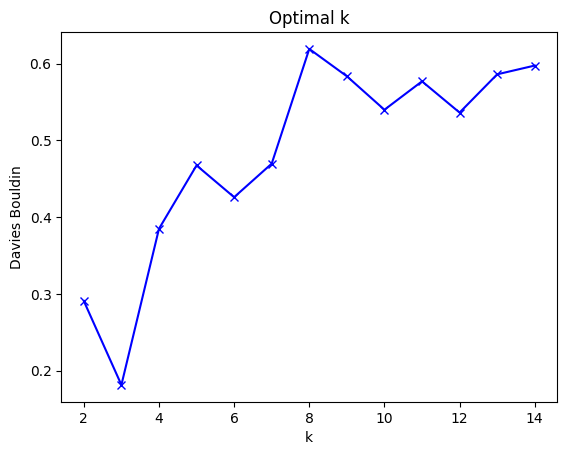

In [25]:
metrics_plots(X_train, max_k=15)

#### Results functions

In [11]:
def drawMap(data, labels):

    gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(X_train_lat_long['longitude'], X_train_lat_long['latitude']))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world[(world.name != "Antarctica")]
    world.plot(figsize=(15, 7), color='lightgray', edgecolor='white')
    gdf.plot(ax=plt.gca(), marker='o', column=labels, markersize=9, legend=True)
    plt.title('Businesses on world map')
    plt.show()

def CountClasters(labels):
    df = pd.DataFrame({"labels": labels})
    value_counts = df["labels"].value_counts()
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')
    plt.title('Distribution of Clusters')
    plt.xlabel('Cluster number')
    plt.ylabel('Number of Bisinesses')
    plt.show()

def calculateScores(data, labels):
    silhouette_avg = silhouette_score(data, labels)
    calinski_score = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    Scores = {
    'Score name': ['Silhouette Score', 'Calinski-Harabaz Index', 'Davies-Bouldin Index'],
    'score value': [silhouette_avg, calinski_score, davies_bouldin]
    }

    df_scores = pd.DataFrame(Scores)
    return df_scores


#### KMeans

In [37]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train)
labels = kmeans.predict(X_train)

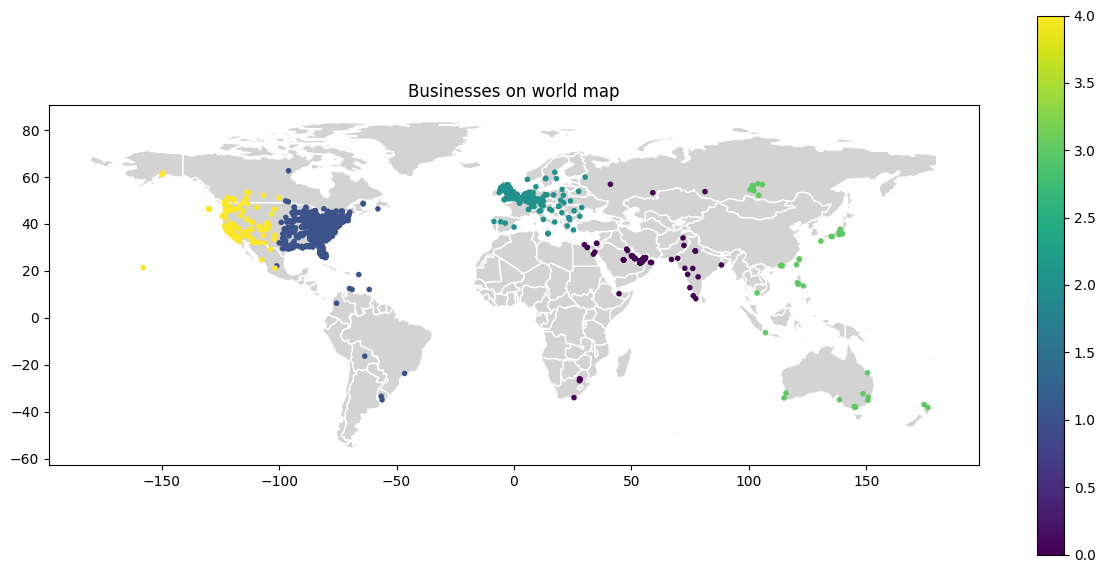

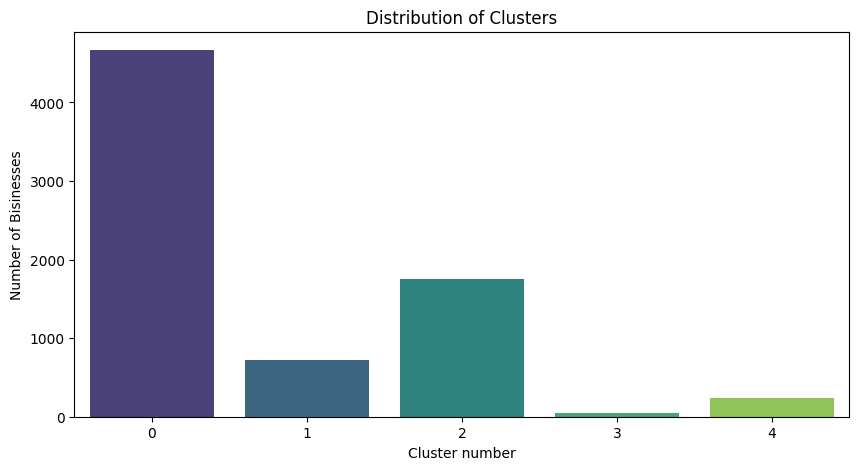

In [38]:
drawMap(X_train, labels)
CountClasters(labels)

In [39]:
calculateScores(X_train, labels)

,Score name,score value
0,Silhouette Score,0.890661
1,Calinski-Harabaz Index,120211.957371
2,Davies-Bouldin Index,0.467421


#### KMedoids

In [28]:
medoids_model = KMedoids(n_clusters=5, random_state=0)
medoids_model.fit(X_train)
labels =  medoids_model.predict(X_train)

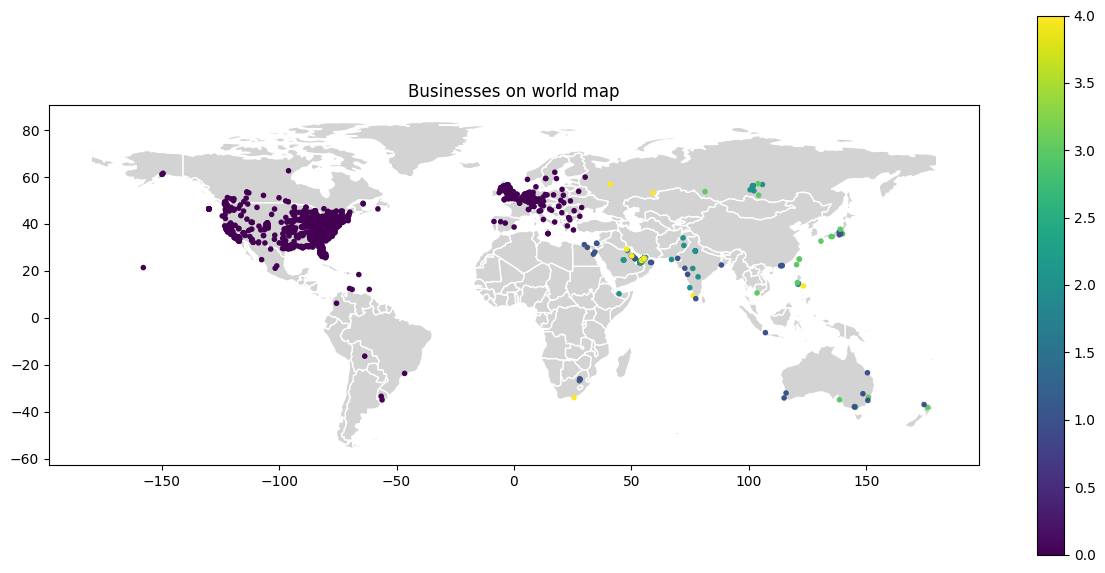

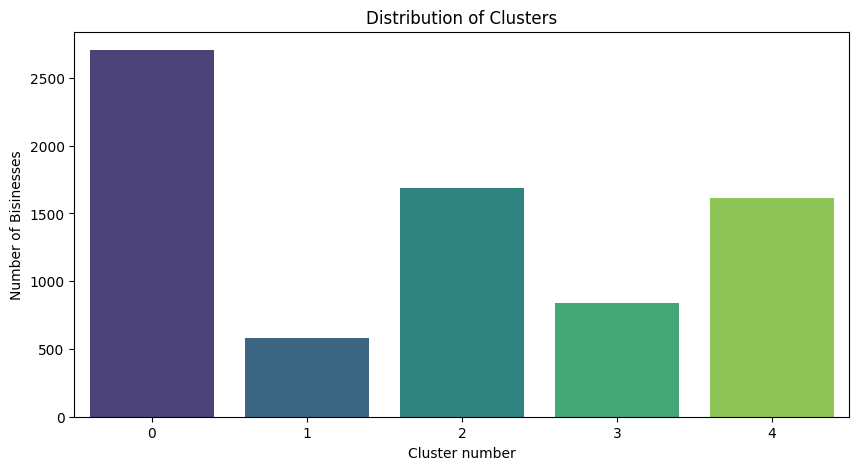

In [29]:
drawMap(X_train, labels)
CountClasters(labels)

In [30]:
calculateScores(X_train, labels)

,Score name,score value
0,Silhouette Score,0.138568
1,Calinski-Harabaz Index,3781.078788
2,Davies-Bouldin Index,2.608965


### Hierarchic models

In [5]:
def linkageGraph(data, method):
    Z = hierarchy.linkage(data, method=method)
    plt.figure(figsize=(10, 20), dpi= 200, facecolor='w', edgecolor='k')
    hierarchy.dendrogram(Z)
    plt.show()
    return Z

#### Single Linkage

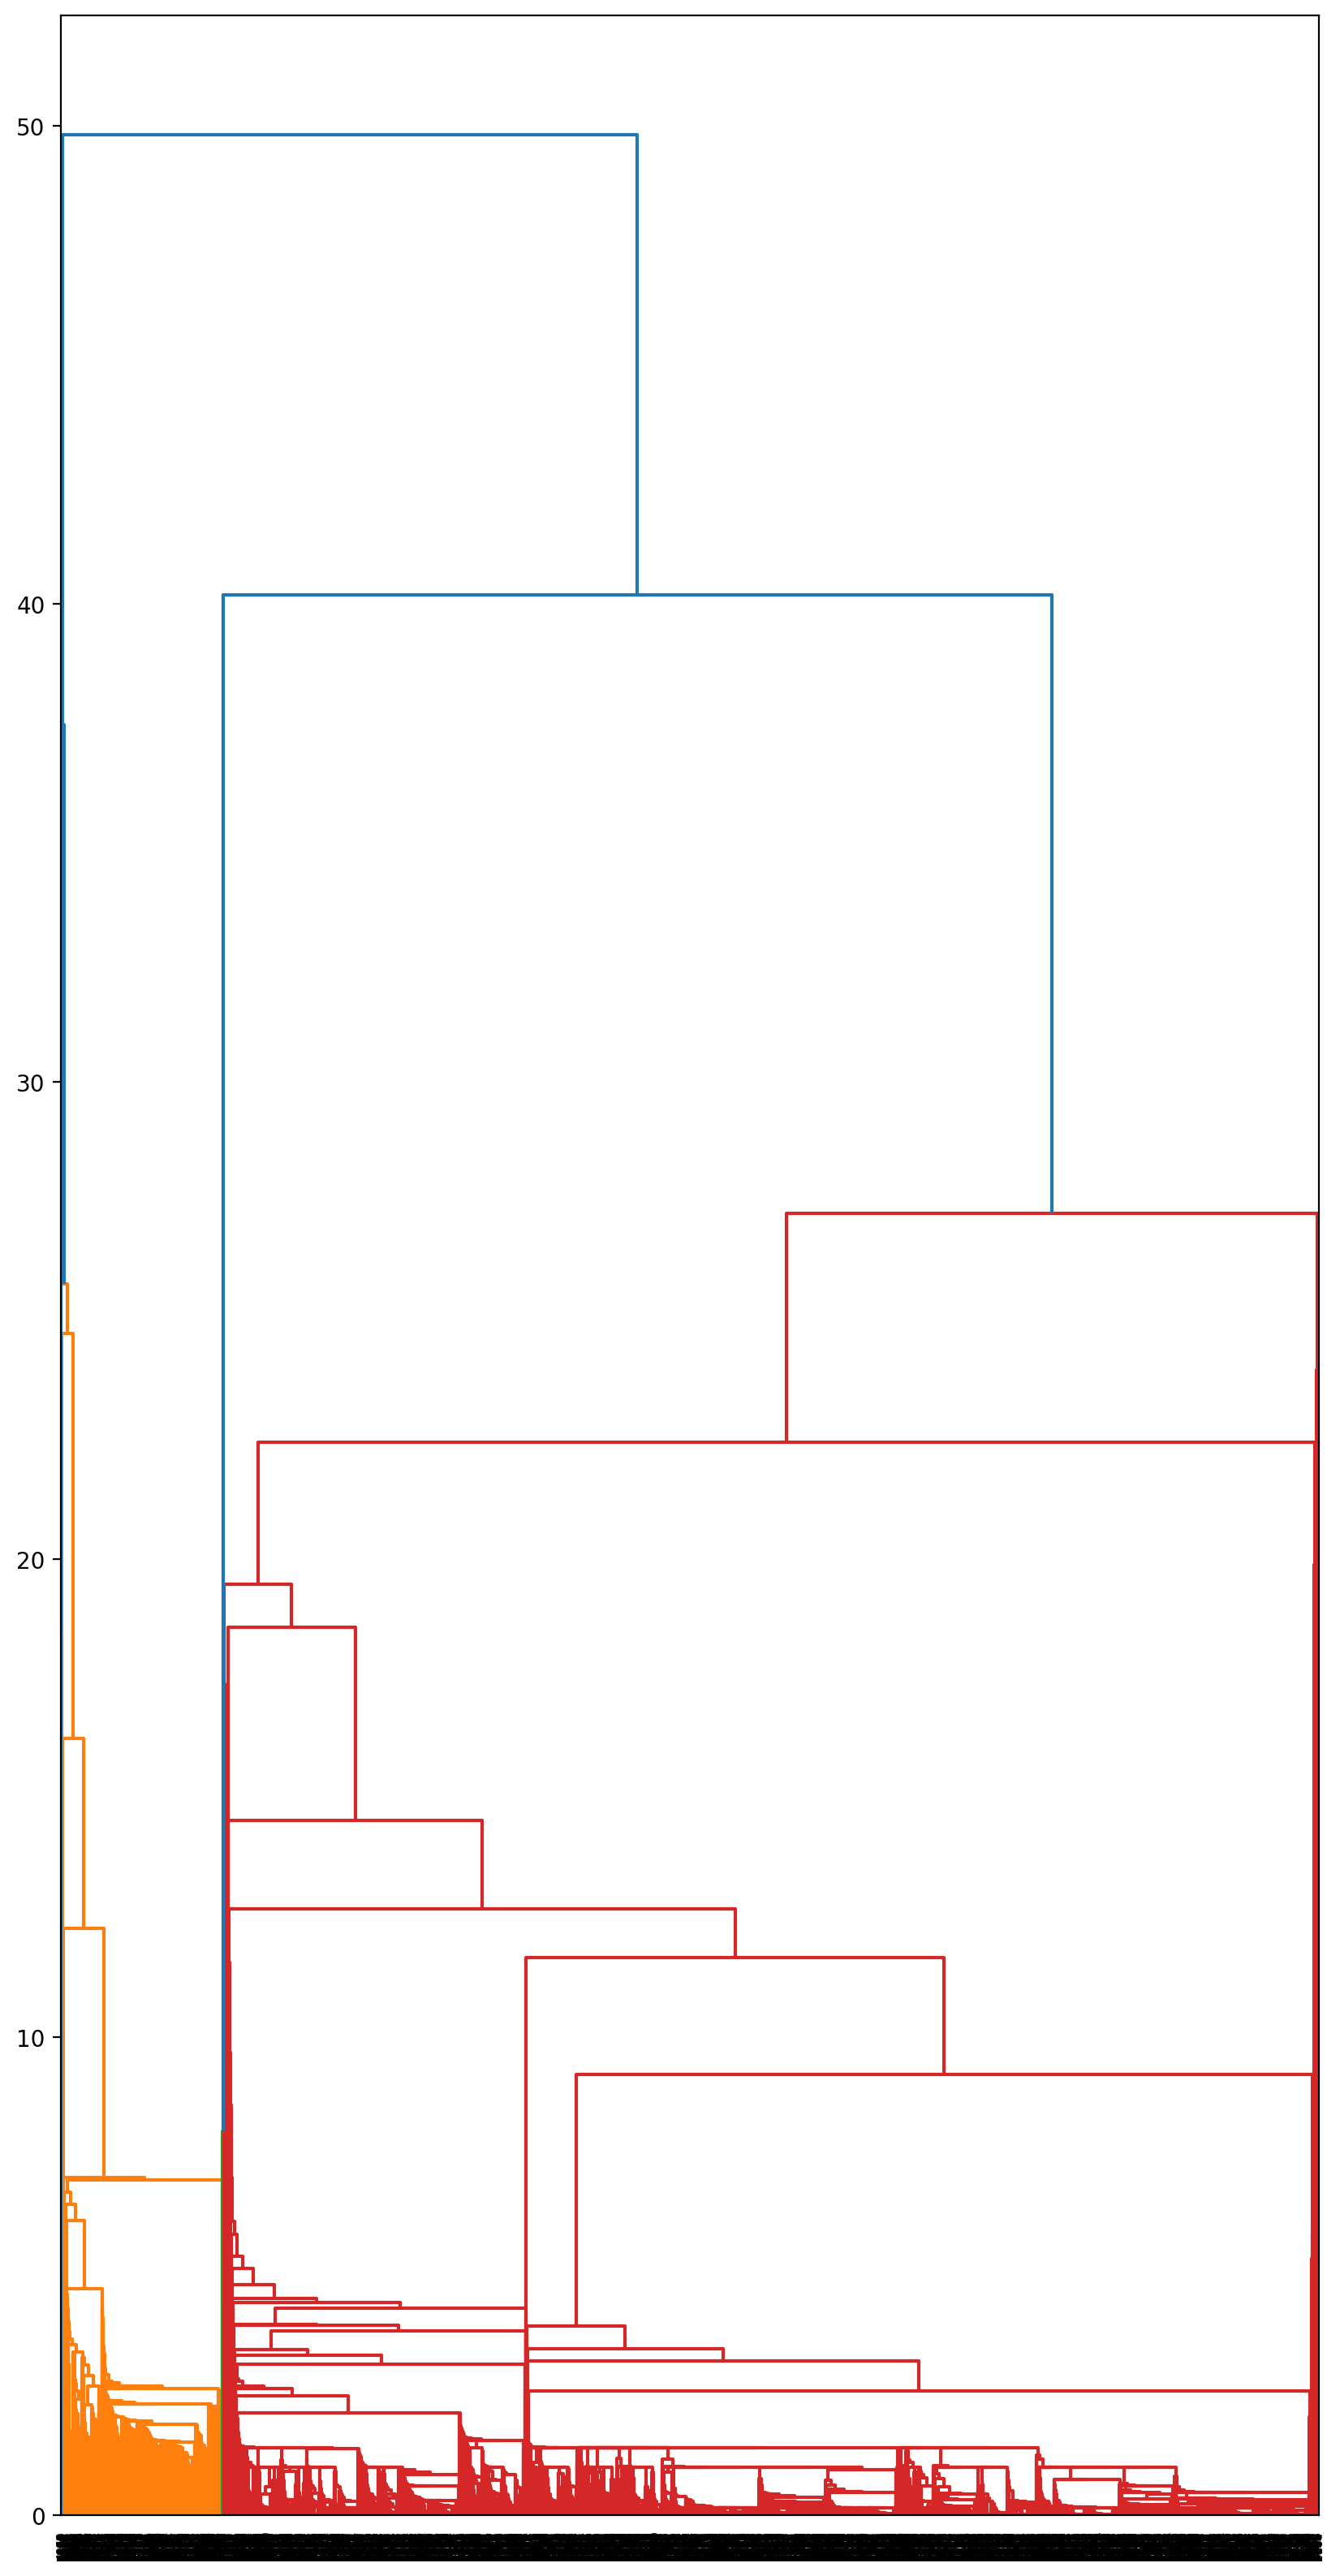

In [6]:
Z = linkageGraph(X_train, 'single')

In [13]:
model = AgglomerativeClustering(n_clusters=None, linkage='single', distance_threshold=25)
labels = model.fit_predict(X_train)

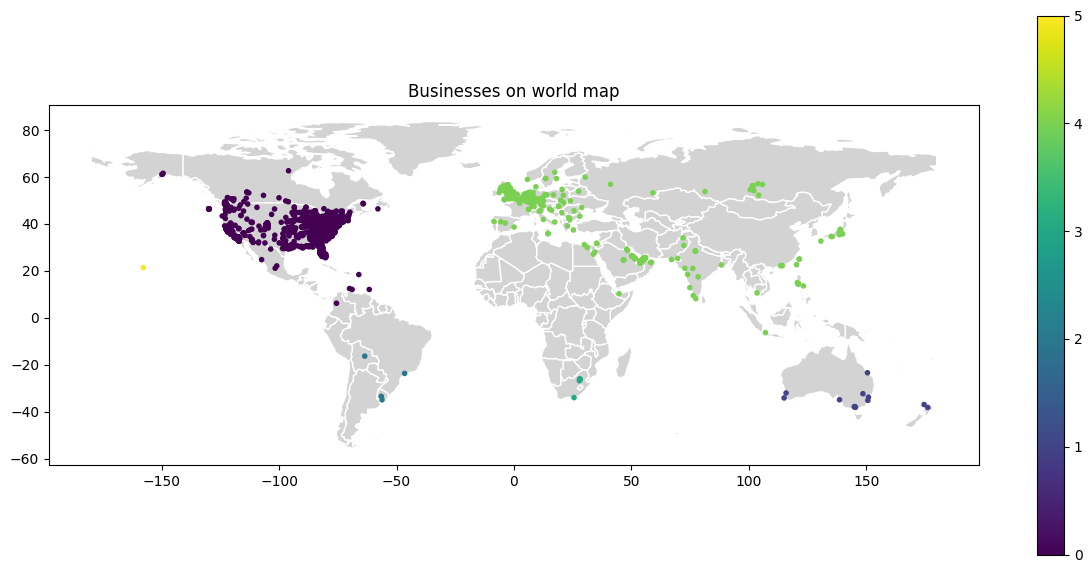

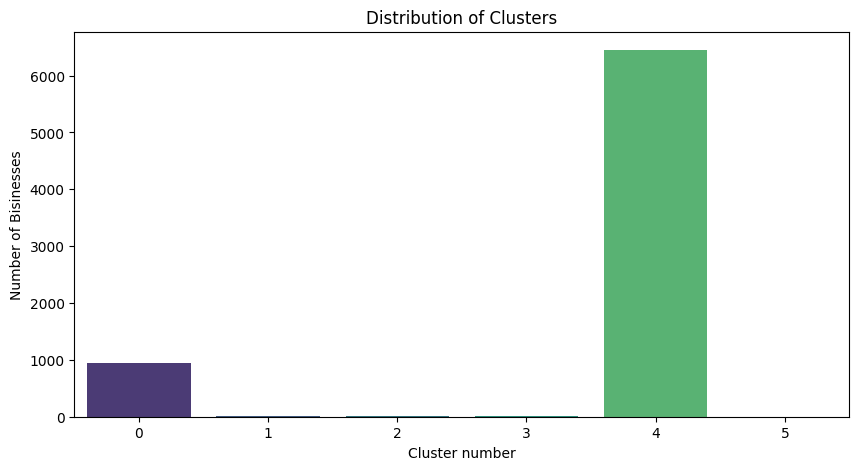

In [14]:
drawMap(X_train, labels)
CountClasters(labels)

In [15]:
calculateScores(X_train, labels)

,Score name,score value
0,Silhouette Score,0.634109
1,Calinski-Harabaz Index,4640.509838
2,Davies-Bouldin Index,0.333668


#### Complete Linkage

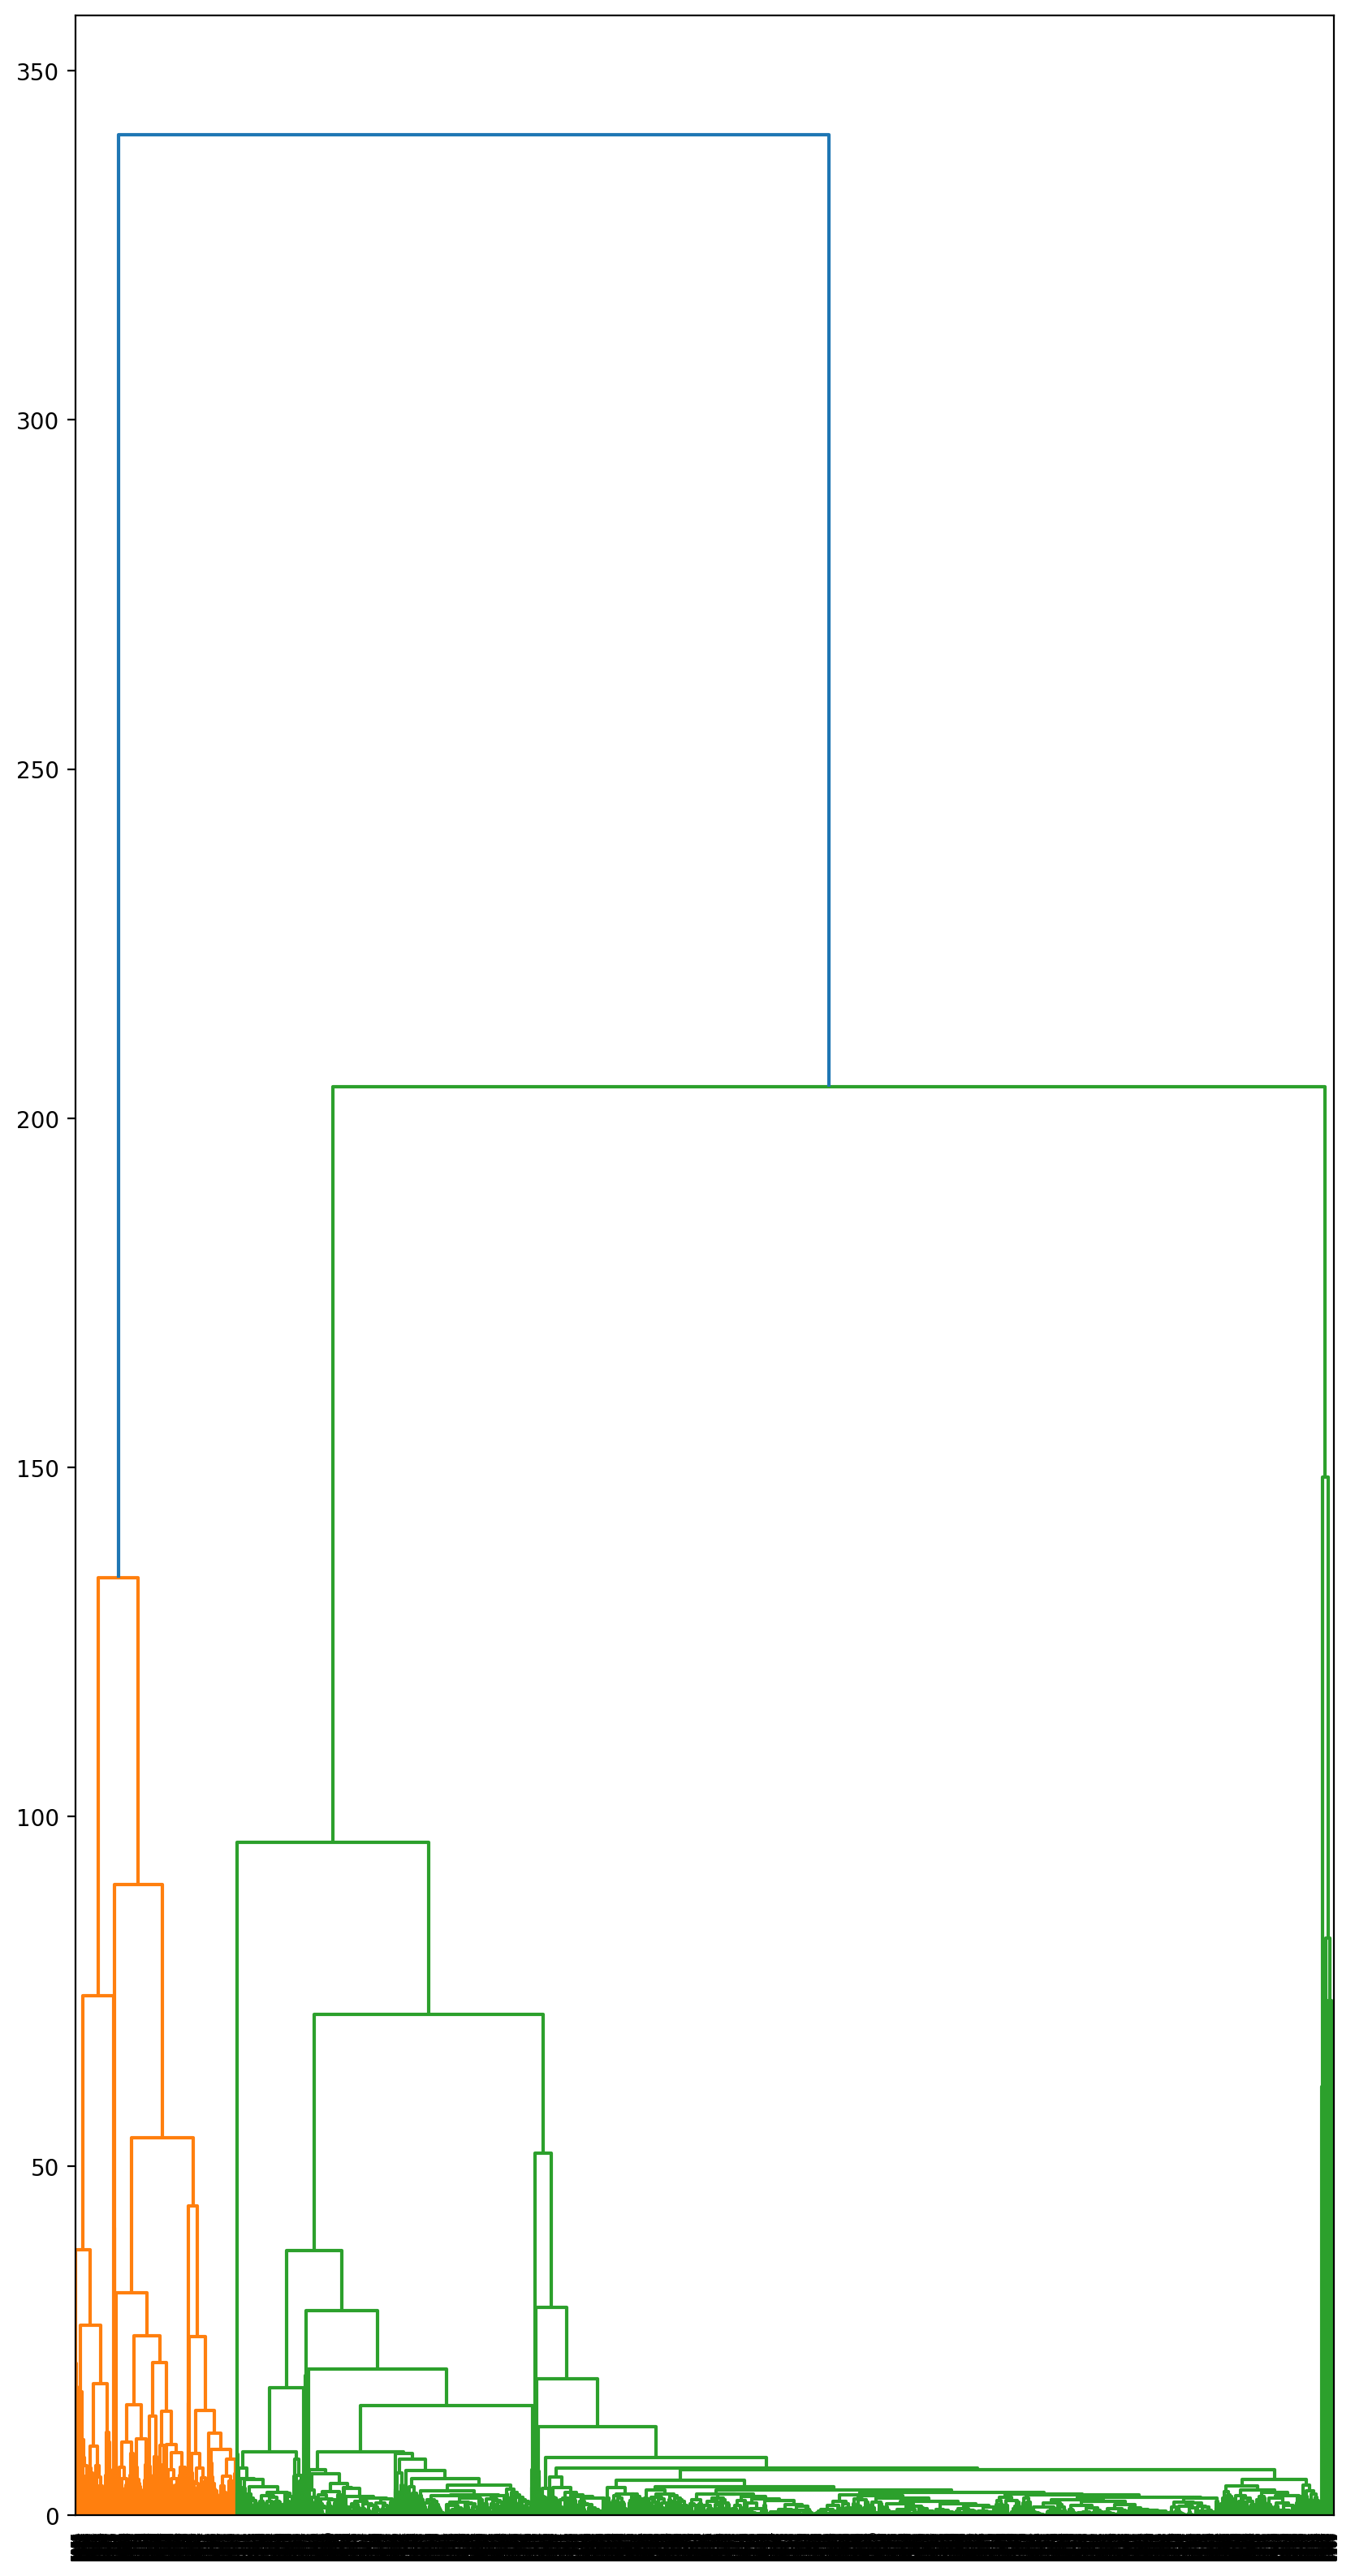

In [24]:
Z = linkageGraph(X_train, 'complete')

In [ ]:
model = AgglomerativeClustering(n_clusters=None, linkage='complete', distance_threshold=150)
labels = model.fit_predict(X_train)

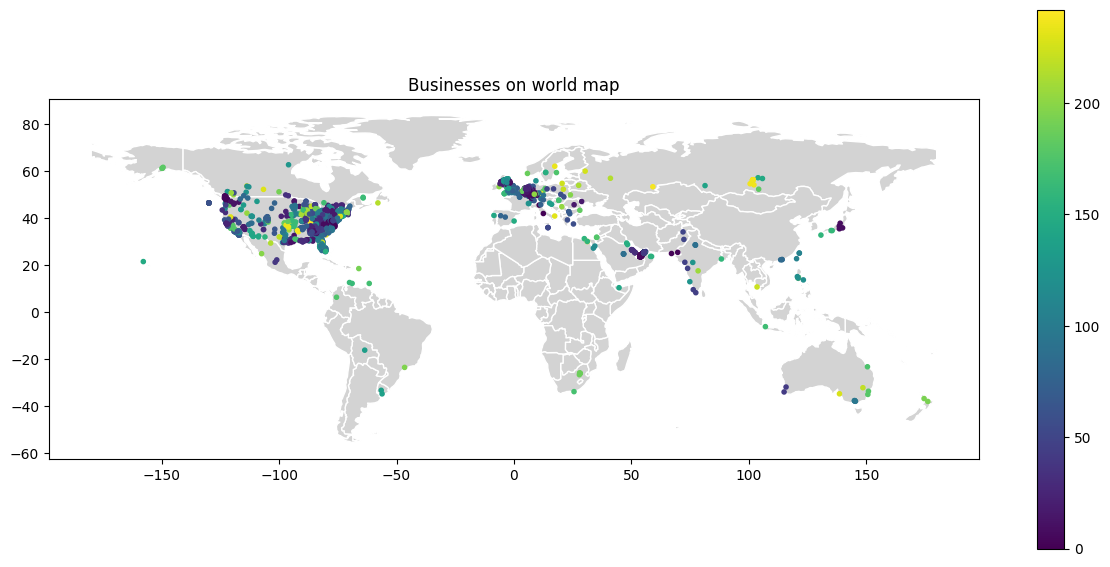

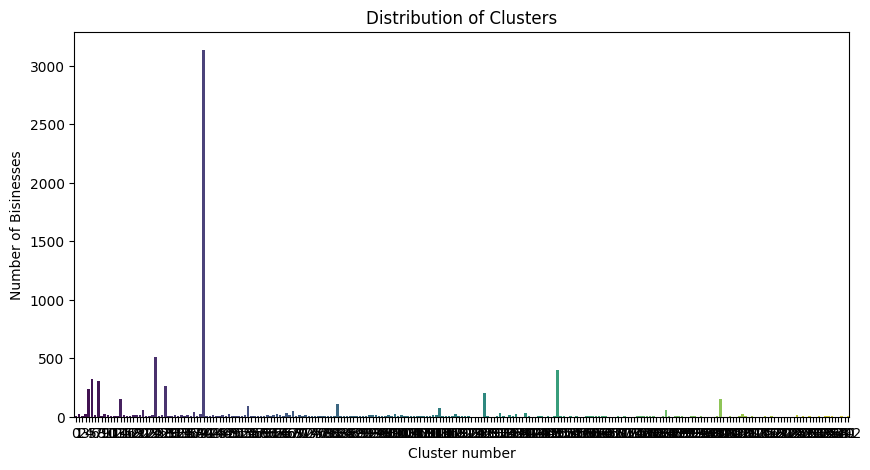

In [32]:
drawMap(X_train, labels)
CountClasters(labels)

In [33]:
calculateScores(X_train, labels)

,Score name,score value
0,Silhouette Score,0.205891
1,Calinski-Harabaz Index,45148.052949
2,Davies-Bouldin Index,0.785218


#### Average Linkage

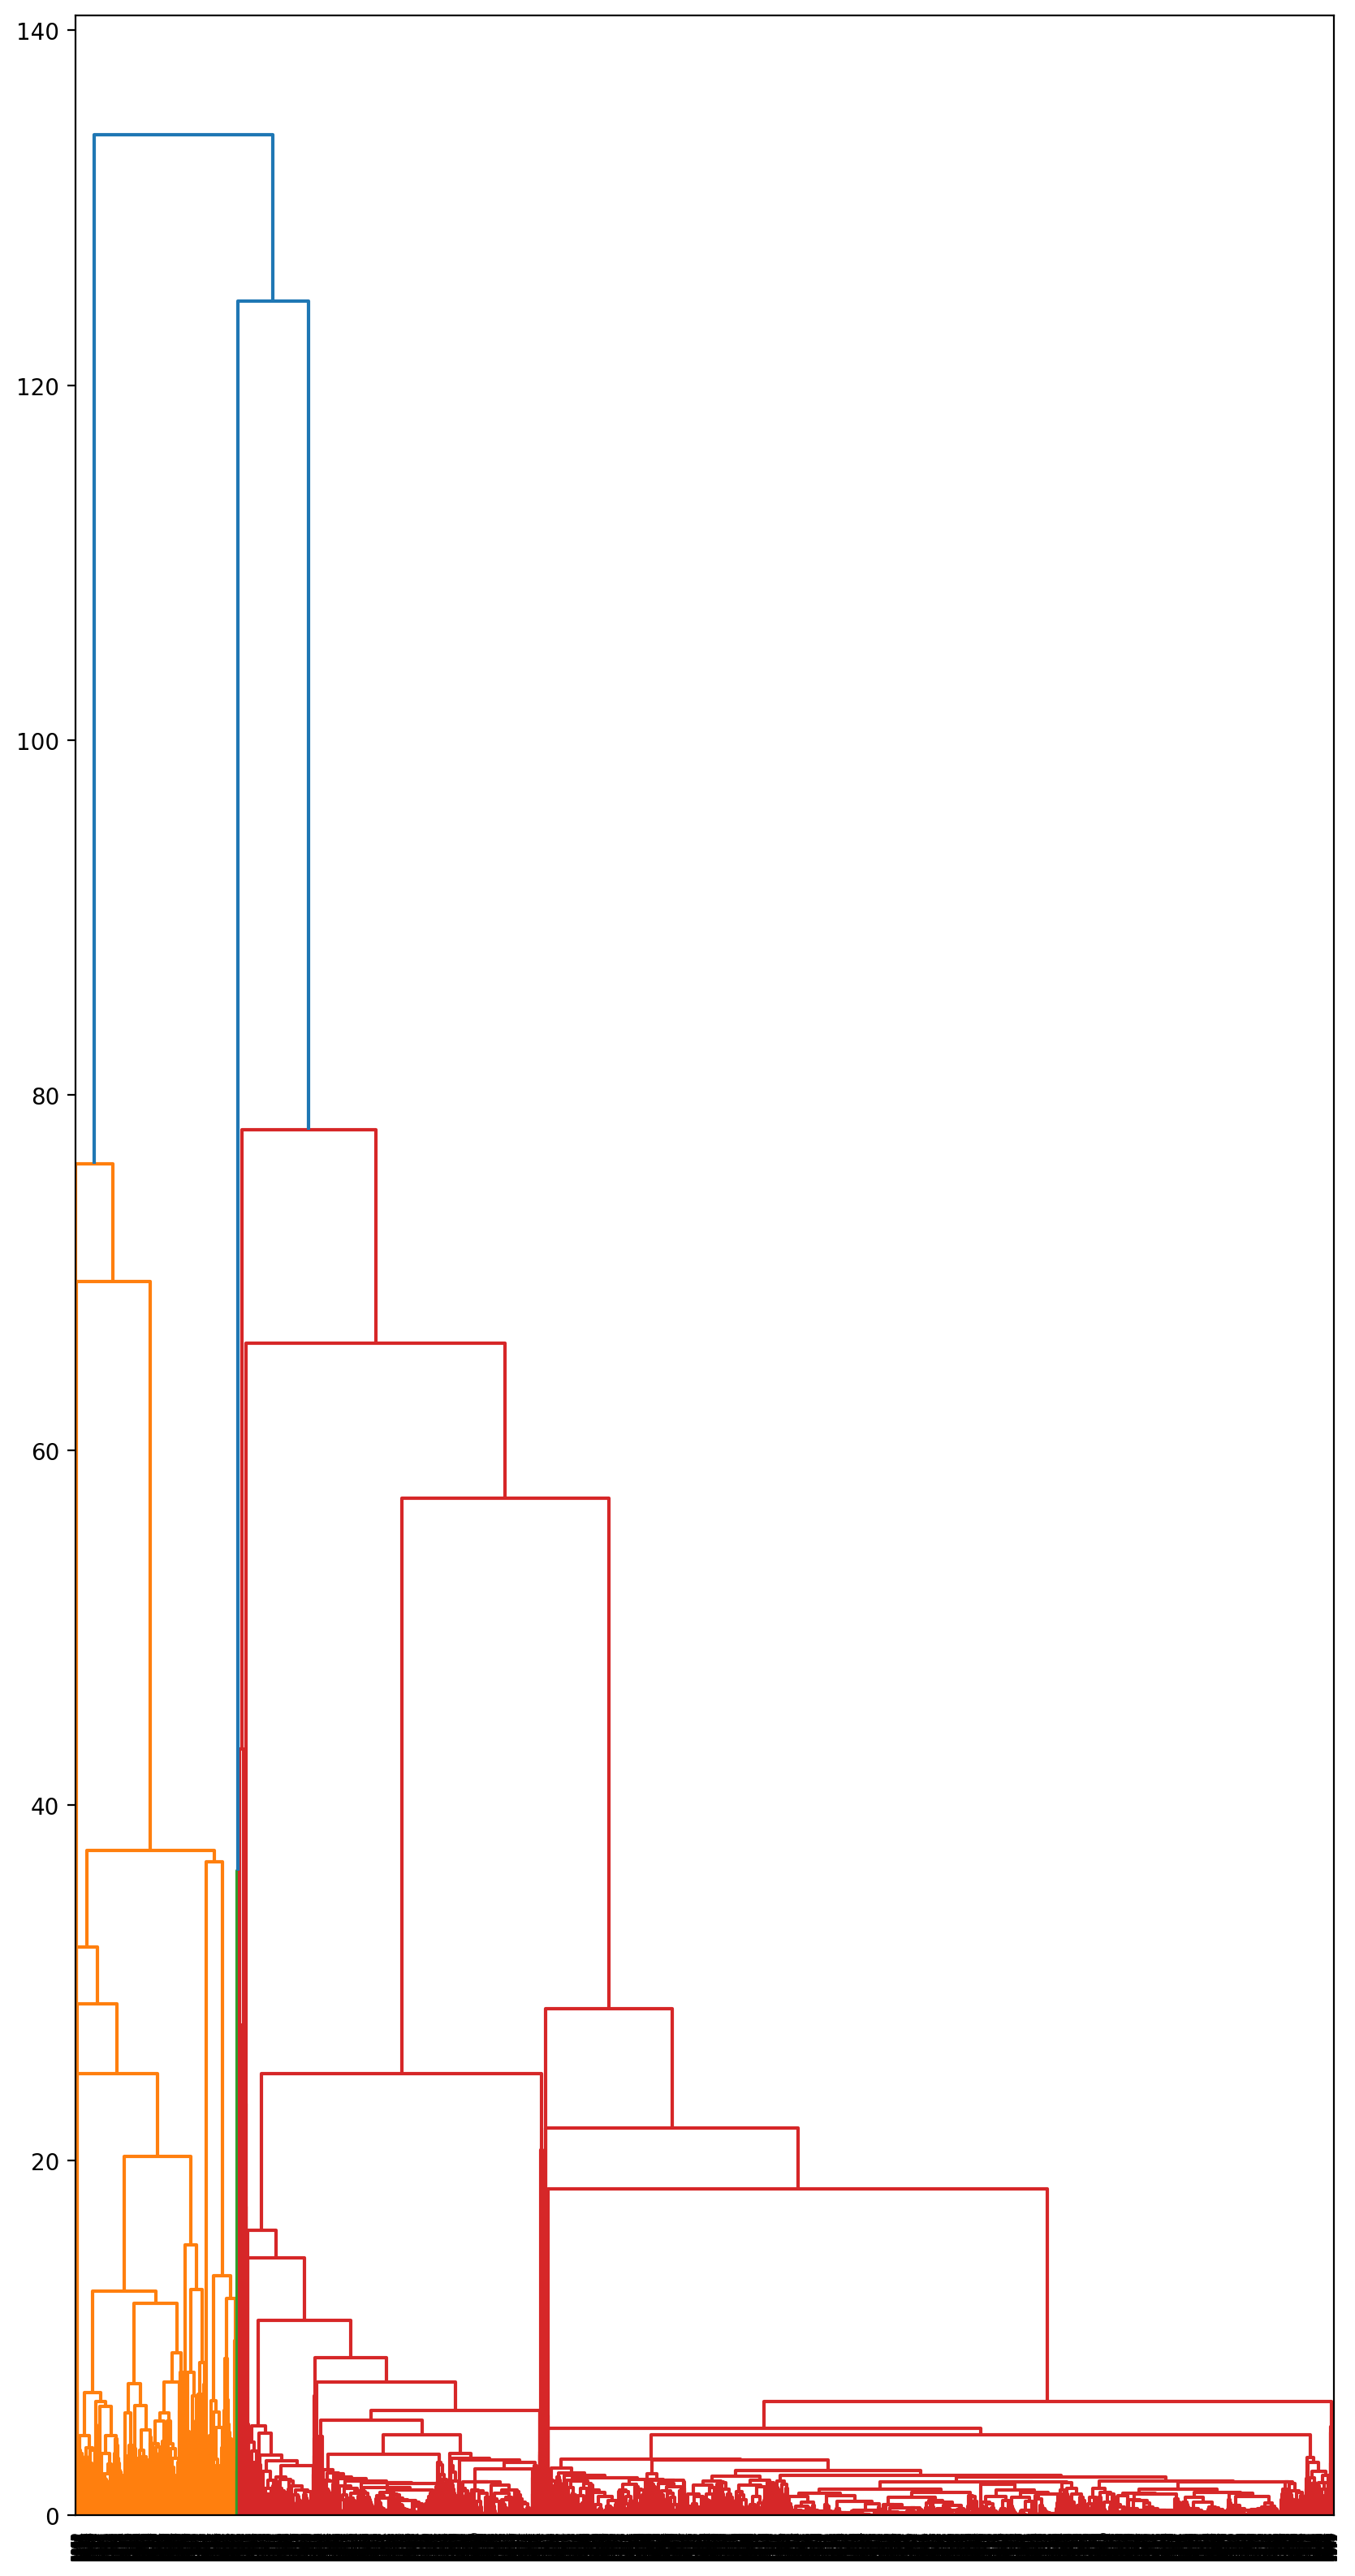

In [16]:
Z = linkageGraph(X_train, 'average')

In [18]:
model = AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=100)
labels = model.fit_predict(X_train)

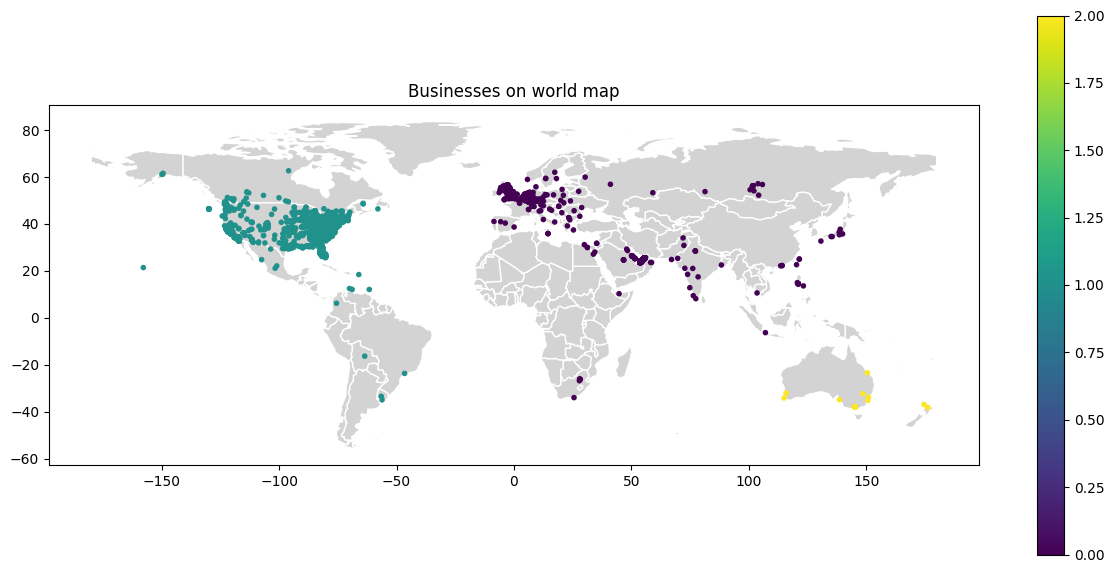

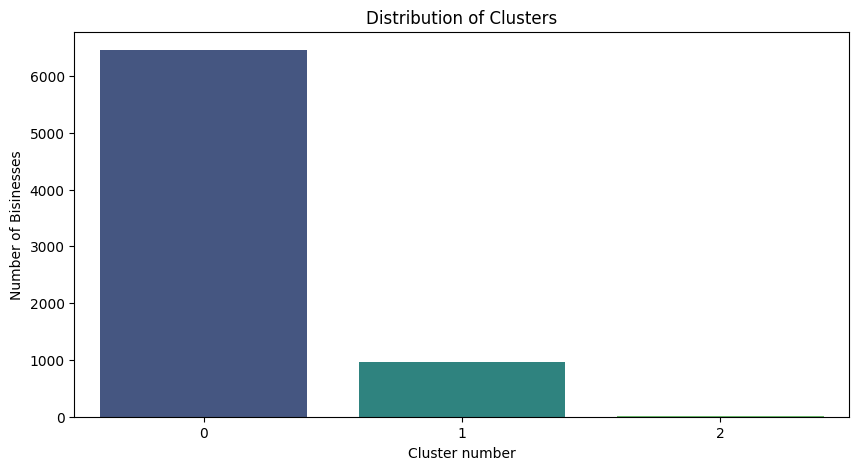

In [19]:
drawMap(X_train, labels)
CountClasters(labels)

In [20]:
calculateScores(X_train, labels)

,Score name,score value
0,Silhouette Score,0.762862
1,Calinski-Harabaz Index,11449.099464
2,Davies-Bouldin Index,0.288405


#### Ward's Linkage

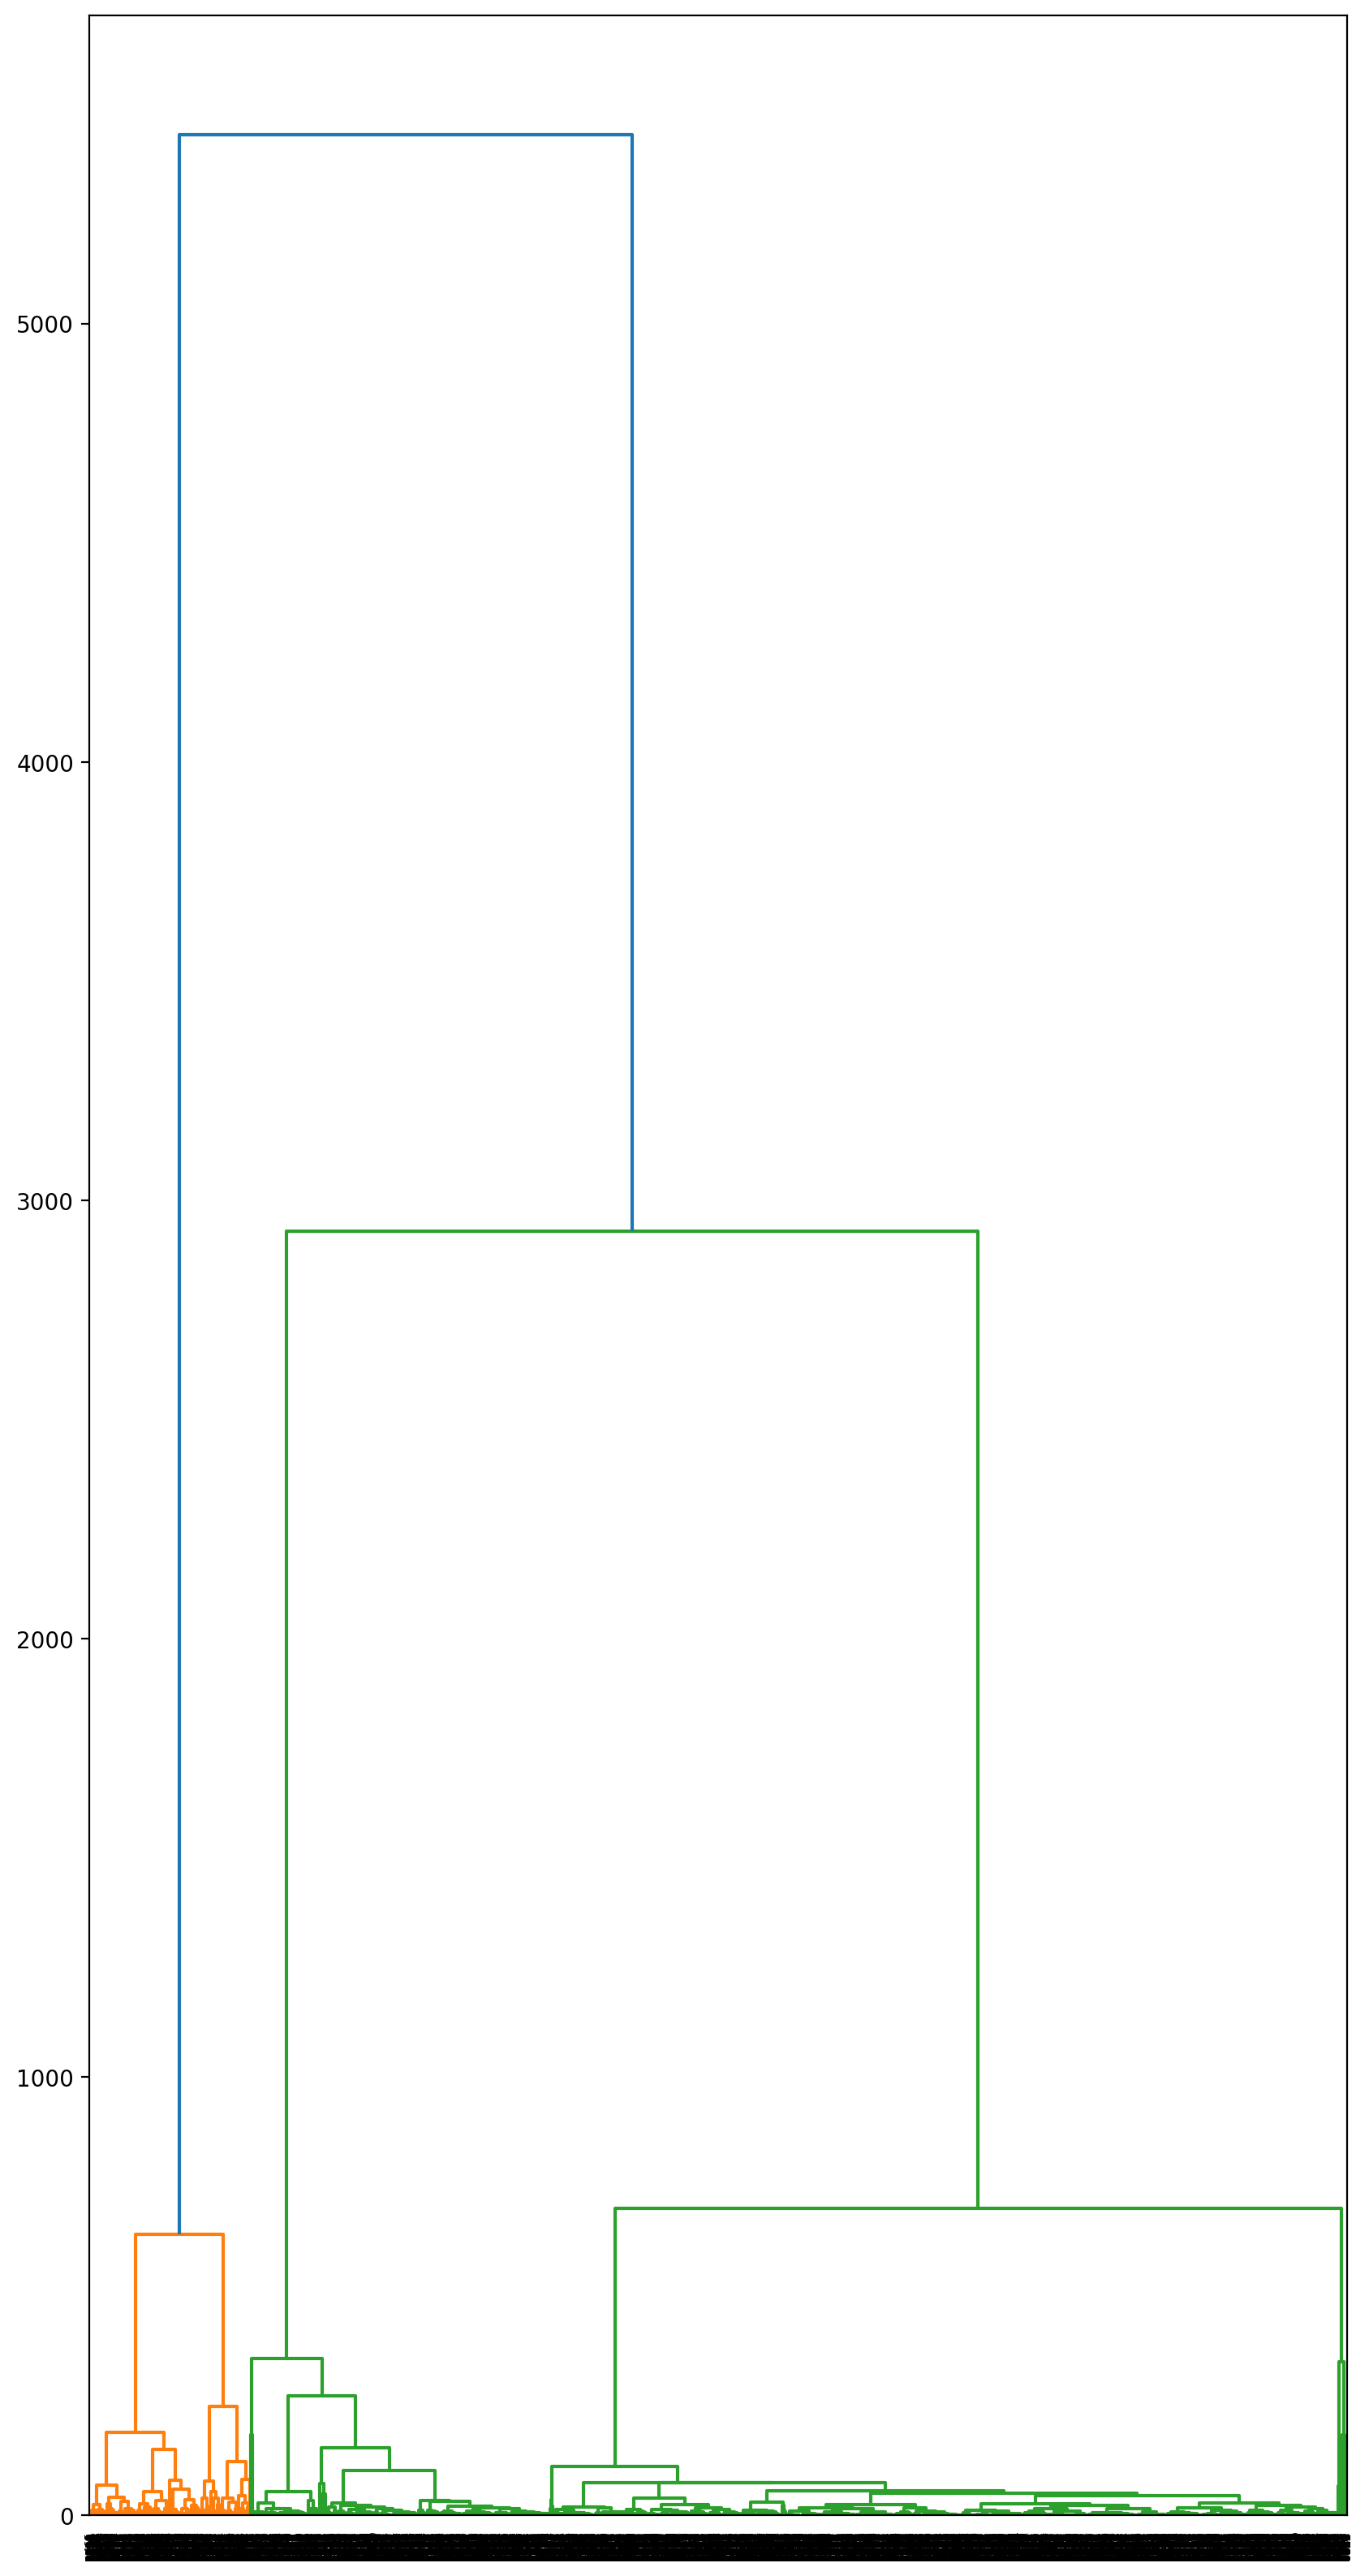

In [23]:
Z = linkageGraph(X_train, 'ward')

In [34]:
model = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=800)
labels = model.fit_predict(X_train)

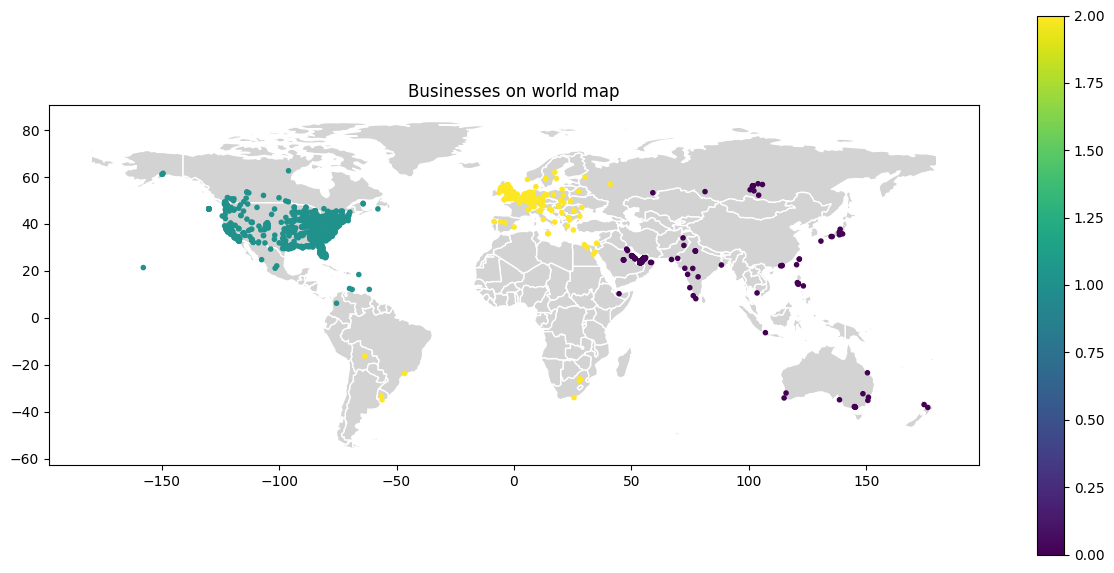

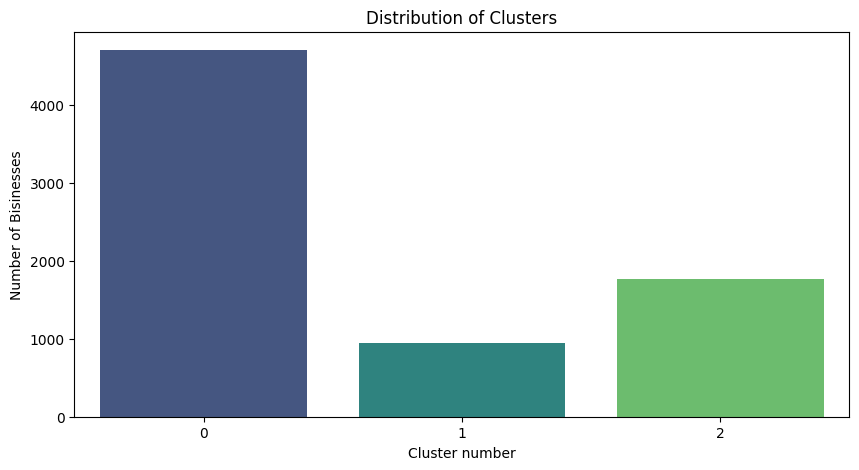

In [35]:
drawMap(X_train, labels)
CountClasters(labels)

In [36]:
calculateScores(X_train, labels)

,Score name,score value
0,Silhouette Score,0.898588
1,Calinski-Harabaz Index,86862.635961
2,Davies-Bouldin Index,0.187630
